# Introducción

Este data set se corresponde con "Energy Consumption Dataset - Linear Regression" (https://www.kaggle.com/datasets/govindaramsriram/energy-consumption-dataset-linear-regression?resource=download)

*Descripción del dataset*:

This dataset is designed for predicting energy consumption based on various building features and environmental factors. It contains data for multiple building types, square footage, the number of occupants, appliances used, average temperature, and the day of the week. The goal is to build a predictive model to estimate energy consumption using these attributes.

The dataset can be used for training machine learning models such as linear regression to forecast energy needs based on the building's characteristics. This is useful for understanding energy demand patterns and optimizing energy consumption in different building types and environmental conditions.

In [1]:
# Importamos las librerías que usaremos:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Lectura de los datos

In [2]:
# Leemos los datos
df = pd.read_csv('train_energy_data.csv')
df

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption
0,Residential,7063,76,10,29.84,Weekday,2713.95
1,Commercial,44372,66,45,16.72,Weekday,5744.99
2,Industrial,19255,37,17,14.30,Weekend,4101.24
3,Residential,13265,14,41,32.82,Weekday,3009.14
4,Commercial,13375,26,18,11.92,Weekday,3279.17
...,...,...,...,...,...,...,...
995,Residential,14419,68,44,23.95,Weekend,3661.21
996,Industrial,12194,7,22,14.67,Weekend,3546.34
997,Commercial,39562,88,20,32.18,Weekday,5147.21
998,Residential,8348,67,37,16.48,Weekend,3244.98


# Modelo: Regresión lineal 

Cogemos los datos que nos indican el tamaño de las viviendas y los que contienen el consumo eléctrico. Los representamos.

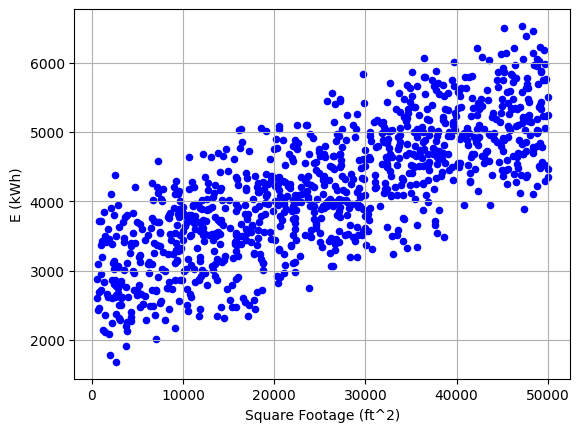

In [3]:
# Graficamos
X = df['Square Footage']
Y = df['Energy Consumption']

plt.scatter(X, Y, s=20, c='blue')
plt.xlabel('Square Footage (ft^2)')
plt.ylabel('E (kWh)')
plt.grid()

# Podemos observar una correlación entre el tamaño de la vivienda y el consumo: mayor tamaño, mayor consumo

Como vemos, existe una correlación entre el tamaño de la vivienda y el consumo eléctrico.

## Aplicación del método del descenso del gradiente 

**- Matemáticamente:**

La recta que buscaremos tendrá la siguiente forma:
$$\hat{y}=wx+b,$$ donde $\hat{y}$ se corresponde con el valor predicho del consumo en base a un valor de tamaño de la vivienda, y $w$ y $b$ serán los parámetros a determinar.

Para hallar los mejores $w$ y $b$ que se ajusten a la nube de puntos, construimos la función de coste: $$J(w,b)=1/2m \sum_{i=1}^{m} \left(\hat{y}_i-y_i\right)^2 = 1/2m \sum_{i=1}^{m} \left(wx_i+b-y_i\right)^2, $$siendo $m$ el número total de elementos del conjunto de entrenamiento y $y_i$ cada uno de los valores reales para cada tamaño de vivienda $x_i$.

Lo único que tenemos que hacer ahora es minimizar la función de coste, esto es, encontrar aquellos $w$ y $b$ que hagan mínima la función de coste. Con ellos, tendremos la mejor recta posible que se ajuste a los datos. Para esta tarea de optimización, usaremos el siguiente conocido algoritmo: el descenso del gradiente. Matemáticamente: $$\vec{v}_{k+1}=\vec{v}_k-\alpha \vec{\nabla} J(w,b),$$ siendo $\vec{v}$ un par $(w,b)$ y $\alpha$ el ratio de aprendizaje (learning rate). Por tanto, $\vec{v}_{0}$ será el valor de $w$ y $b$ que escojamos inicialmente y que dé comienzo el método (la iteración inicial).

Además del descenso del gradiente, este problema tiene una solución exacta en términos cerrados. Si prestamos atención a nuestra función de coste, los valores óptimos de $w$ y $b$ se obtienen anulando las derivadas parciales:  
$$
\frac{\partial J}{\partial w}=0, \qquad \frac{\partial J}{\partial b}=0.
$$  

De este sistema se llega a las fórmulas de mínimos cuadrados:  

$$
w^* = \frac{\sum_{i=1}^{m}(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^{m}(x_i-\bar{x})^2}, 
\qquad 
b^* = \bar{y} - w^* \bar{x},
$$  

donde $\bar{x} = \tfrac{1}{m}\sum_i x_i$ y $\bar{y} = \tfrac{1}{m}\sum_i y_i$.  

Así, el descenso del gradiente es un método numérico iterativo para aproximar esta misma solución exacta cuando el cálculo cerrado no es práctico o se generaliza a más dimensiones.


**- En Python:**

In [4]:
y=Y

def batch_gradient_descent(X, y, lr=0.01, epochs=1000, w0=0.0, b0=0.0,
                           tol=1e-9, verbose=False, normalize=False):
    """
    Ejecuta descenso por gradiente batch para y = w * x + b minimizando MSE.

    Parámetros
    ----------
    X : array-like, shape (n_samples,)
        Valores de la variable independiente.
    y : array-like, shape (n_samples,)
        Valores objetivo.
    lr : float
        Tasa de aprendizaje (learning rate).
    epochs : int
        Número máximo de iteraciones.
    w0, b0 : floats
        Valores iniciales para w y b.
    tol : float
        Tolerancia para parar si la mejora en la pérdida es menor que tol.
    verbose : bool
        Si True imprime progreso intermitente.
    normalize : bool
        Si True normaliza X (media 0, desviación 1) para acelerar convergencia.
    
    Retorna
    -------
    params : dict
        {'w': w_final, 'b': b_final}
    history : dict
        {'loss': list_de_loss, 'w': list_de_w, 'b': list_de_b}
    """
    X = np.asarray(X, dtype=float).reshape(-1)
    y = np.asarray(y, dtype=float).reshape(-1)
    n = X.shape[0]
    if n == 0:
        raise ValueError("X e y deben contener al menos un elemento")

    # Normalización opcional (guardamos parámetros para devolver predicciones correctas)
    if normalize:
        X_mean = X.mean()
        X_std = X.std()
        if X_std == 0:
            X_std = 1.0
        Xn = (X - X_mean) / X_std
    else:
        Xn = X.copy()
        X_mean = 0.0
        X_std = 1.0

    w = float(w0)
    b = float(b0)

    loss_history = []
    w_history = []
    b_history = []

    prev_loss = None
    for epoch in range(1, epochs + 1):
        # Predicción y error
        y_pred = w * Xn + b
        error = y_pred - y

        # MSE (media de errores al cuadrado)
        loss = (error ** 2).mean()
        loss_history.append(loss)
        w_history.append(w)
        b_history.append(b)

        # Gradientes de MSE: dL/dw = (2/n) * sum(error * x), dL/db = (2/n) * sum(error)
        dw = (2.0 / n) * np.dot(error, Xn)
        db = (2.0 / n) * error.sum()

        # Actualización de parámetros
        w -= lr * dw
        b -= lr * db

        # Condición de parada por mejoría pequeña
        if prev_loss is not None and abs(prev_loss - loss) < tol:
            if verbose:
                print(f"[epoch {epoch}] parada por tol (mejora {abs(prev_loss-loss):.3e} < {tol})")
            break
        prev_loss = loss

        if verbose and (epoch % (epochs // 10 or 1) == 0):
            print(f"epoch {epoch:4d} | loss: {loss:.6f} | w: {w:.6f} | b: {b:.6f}")

    # Si normalizamos, convertir w,b a escala original:
    # y = w_norm * ((x - mean)/std) + b_norm = (w_norm/std) * x + (b_norm - w_norm*mean/std)
    w_original = w / X_std
    b_original = b - (w * X_mean / X_std)

    params = {'w': w_original, 'b': b_original}
    history = {'loss': loss_history, 'w': w_history, 'b': b_history}
    return params, history

def predict(X, params):
    X = np.asarray(X, dtype=float)
    return params['w'] * X + params['b']


[epoch 187] parada por tol (mejora 0.000e+00 < 1e-12)

Parámetros encontrados:
w = 0.050593, b = 2878.044038
Solución closed-form (np.polyfit): w = 0.050593, b = 2878.044046


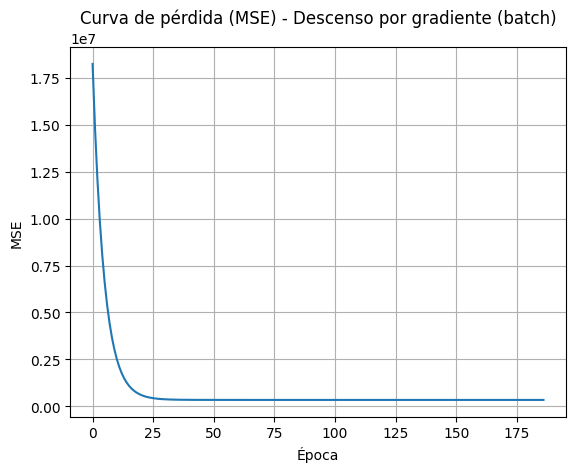

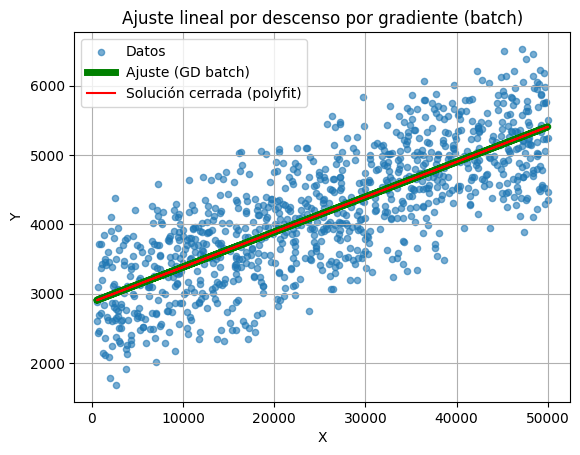

In [5]:
# ----------------- Ejemplo de uso -----------------
if __name__ == "__main__":
    
    # Hiperparámetros
    lr = 0.05
    epochs = 5000
    w0, b0 = 0.0, 0.0
    normalize = True

    # Entrenar
    params, history = batch_gradient_descent(X, Y, lr=lr, epochs=epochs,
                                            w0=w0, b0=b0, tol=1e-12,
                                            verbose=True, normalize=normalize)

    print("\nParámetros encontrados:")
    print(f"w = {params['w']:.6f}, b = {params['b']:.6f}")

    # Comparar con numpy.polyfit (solución cerrada para grado 1)
    w_np, b_np = np.polyfit(X, y, 1)
    print(f"Solución closed-form (np.polyfit): w = {w_np:.6f}, b = {b_np:.6f}")

    # Predicciones
    y_pred = predict(X, params)

    # Gráfico 1: pérdida vs época
    plt.figure()
    plt.plot(history['loss'])
    plt.xlabel("Época")
    plt.ylabel("MSE")
    plt.title("Curva de pérdida (MSE) - Descenso por gradiente (batch)")
    plt.grid(True)

    # Gráfico 2: ajuste y datos
    plt.figure()
    plt.scatter(X, y, s=20, alpha=0.6, label="Datos")
    plt.plot(X, y_pred, linewidth=5, color='green', label="Ajuste (GD batch)")
    plt.plot(X, w_np * X + b_np, linewidth=1.5, linestyle='-', color='red', label="Solución cerrada (polyfit)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Ajuste lineal por descenso por gradiente (batch)")
    plt.legend()
    plt.grid(True)

    plt.show()

# Evaluación del resultado

Hemos obtenido la siguiente recta: 
$$\hat{y} = 0.05 x + 2878.04$$

¿Cuál es su significado? Pues que el consumo eléctrico base para cualquier vivienda de las estudiadas, independientemente a su tamaño, es de 2878.04 kWh. A partir de ahí, por cada aumento del tamaño de vivienda de un 1 pie al cuadrado, el consumo eléctrico aumenta 0.05 kWh. Si el tamaño de esta muestra de datos fuese representativo, tendríamos una estimación de cuál sería el consumo eléctrico para cualquier tamaño de vivienda. Con lo cual:

- **Consumo base**: $2878.04\, kWh$
- **Consumo adicional por pie al cuadrado**: $0.05\,kWh/ft^2$

# Conclusiones y resumen ejecutivo

- Existe un **consumo base garantizado** de ~2878 kWh por vivienda, independientemente de su tamaño.  
- Por cada pie cuadrado adicional de superficie, el consumo eléctrico promedio aumenta en **0.05 kWh**.  

**Implicaciones de negocio:**
- **Ingresos mínimos estables por cliente**, ya que todo hogar tiene un consumo fijo.  
- **Mayor potencial de consumo en viviendas grandes**, lo que permite segmentar clientes y diseñar ofertas específicas.  
- **Mejor planificación de la demanda**, al estimar consumo total a partir de la distribución de tamaños de vivienda.  
